## Colab Setup

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
!pip install Keras==2.1

  Using cached https://files.pythonhosted.org/packages/bf/c2/b0c2ece713e754d1692aa432ad682751cd1ad6abf7500a534558b1fbfbe7/Keras-2.1.0-py2.py3-none-any.whl
ERROR: textgenrnn 1.4.1 has requirement keras>=2.1.5, but you'll have keras 2.1.0 which is incompatible.
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [ ]:
!pip list

Package                       Version        
----------------------------- ---------------
absl-py                       0.10.0         
alabaster                     0.7.12         
albumentations                0.1.12         
altair                        4.1.0          
argon2-cffi                   20.1.0         
asgiref                       3.2.10         
astor                         0.8.1          
astropy                       4.1            
astunparse                    1.6.3          
async-generator               1.10           
atari-py                      0.2.6          
atomicwrites                  1.4.0          
attrs                         20.2.0         
audioread                     2.1.9          
autograd                      1.3            
Babel                         2.8.0          
backcall                      0.2.0          
backports.tempfile            1.0            
backports.weakref             1.0.post1      
beautifulsoup4                4.6.

In [ ]:
# mounting and connecting with drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# # Setup colab
# !pip install -U -q PyDrive
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials
# # Authenticate and create the PyDrive client.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

In [ ]:
import warnings 
warnings.filterwarnings("ignore")

In [ ]:
# # importing train file from gdrive
# link = 'https://drive.google.com/open?id=1-EME5voRfDtwq6iS1Zm9VuQnhSTkK6Ee' # Paste the shareable link here

# fluff, id = link.split('=')
# print (id) # Verify that you have everything after '='

# downloaded = drive.CreateFile({'id':id}) 
# downloaded.GetContentFile('train.csv') # file will be stored as train.csv in the colab directory

1-EME5voRfDtwq6iS1Zm9VuQnhSTkK6Ee


In [ ]:
# # importing labels file from gdrive
# link = 'https://drive.google.com/open?id=1i6AIWVIyA4ECPFgoWrwQwASShbuNMmkr' # Paste the shareable link here

# fluff, id = link.split('=')
# print (id) # Verify that you have everything after '='

# downloaded = drive.CreateFile({'id':id}) 
# downloaded.GetContentFile('labels.json')

1i6AIWVIyA4ECPFgoWrwQwASShbuNMmkr


In [ ]:
# importing libraries
import os
import gc
import sys
import math
import json
import glob
import random
from pathlib import Path

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import skimage.io
from IPython.display import clear_output

import itertools
from tqdm import tqdm

from imgaug import augmenters as iaa
from sklearn.model_selection import StratifiedKFold, KFold

import tensorflow as tf

In [ ]:
# setting up path directory
TRAIN_IMAGE_DIR = Path('/content/drive/My Drive/myntra /Train large/')
ROOT_DIR = Path('/content/')
DATA_DIR = Path('/content/drive/My Drive/myntra /')

## Data Import

In [ ]:
# import train file 
import pandas as pd
train = pd.read_csv('/content/drive/My Drive/myntra /train.csv')
train.head()

ImageId  ... ClassId
0  00000663ed1ff0c4e0132b9b9ac53f6e.jpg  ...       6
1  00000663ed1ff0c4e0132b9b9ac53f6e.jpg  ...       0
2  00000663ed1ff0c4e0132b9b9ac53f6e.jpg  ...      28
3  00000663ed1ff0c4e0132b9b9ac53f6e.jpg  ...      31
4  00000663ed1ff0c4e0132b9b9ac53f6e.jpg  ...      32

[5 rows x 5 columns]

In [ ]:
# extracting image metadata fom json file 
with open(DATA_DIR/"labels.json") as f:
    label_descriptions = json.load(f)

label_names = [x['name'] for x in label_descriptions['categories']]

In [ ]:
label_df = pd.DataFrame(label_names).reset_index()
label_df.columns = ['Id','Labels']
label_df.head()

Id                    Labels
0   0             shirt, blouse
1   1  top, t-shirt, sweatshirt
2   2                   sweater
3   3                  cardigan
4   4                    jacket

In [ ]:
segment_df = train
segment_df['CategoryId'] = segment_df['ClassId'].str.split('_').str[0]

print("Total segments: ", len(segment_df))
segment_df.head()

Total segments:  331213


ImageId  ... CategoryId
0  00000663ed1ff0c4e0132b9b9ac53f6e.jpg  ...          6
1  00000663ed1ff0c4e0132b9b9ac53f6e.jpg  ...          0
2  00000663ed1ff0c4e0132b9b9ac53f6e.jpg  ...         28
3  00000663ed1ff0c4e0132b9b9ac53f6e.jpg  ...         31
4  00000663ed1ff0c4e0132b9b9ac53f6e.jpg  ...         32

[5 rows x 6 columns]

In [ ]:
# Rows with the same image are grouped together because the subsequent operations perform at an image level
image_df = segment_df.groupby('ImageId')['EncodedPixels', 'CategoryId'].agg(lambda x: list(x))
size_df = segment_df.groupby('ImageId')['Height', 'Width'].mean()
image_df = image_df.join(size_df, on='ImageId')

print("Total images: ", len(image_df))
image_df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


Total images:  45195


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


EncodedPixels  ... Width
ImageId                                                                                  ...      
00000663ed1ff0c4e0132b9b9ac53f6e.jpg  [6068157 7 6073371 20 6078584 34 6083797 48 60...  ...  3676
0000fe7c9191fba733c8a69cfaf962b7.jpg  [2201176 1 2203623 3 2206071 5 2208518 8 22109...  ...  2448
0002ec21ddb8477e98b2cbb87ea2e269.jpg  [2673735 2 2676734 8 2679734 13 2682733 19 268...  ...  1997
0002f5a0ebc162ecfb73e2c91e3b8f62.jpg  [435 132 1002 132 1569 132 2136 132 2703 132 3...  ...   400
0004467156e47b0eb6de4aa6479cbd15.jpg  [132663 8 133396 25 134130 41 134868 53 135611...  ...   500

[5 rows x 4 columns]

## EDA

<Figure size 1080x504 with 0 Axes>

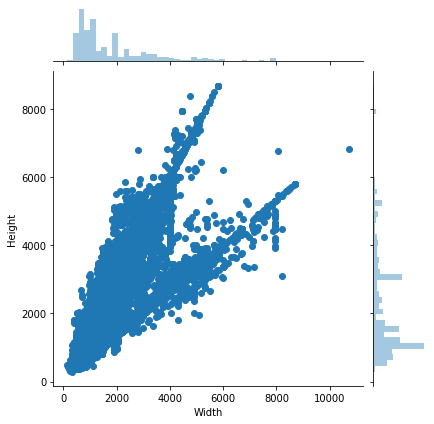

In [ ]:
plt.figure(figsize=(15, 7))
sns.jointplot(x=image_df['Width'], y=image_df['Height'])

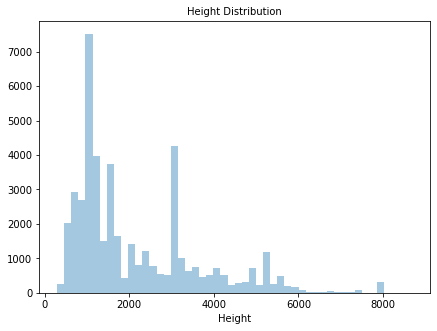

In [ ]:
plt.figure(figsize=(7, 5))
sns.distplot(image_df['Height'], kde=False);
plt.title("Height Distribution", fontsize=10)
plt.show()

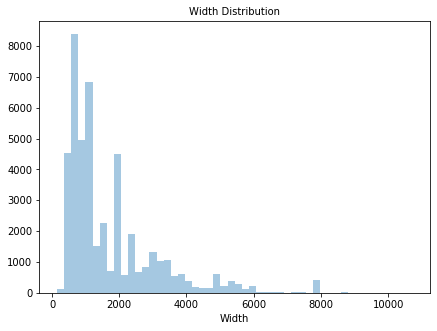

In [ ]:
plt.figure(figsize=(7, 5))
sns.distplot(image_df['Width'], kde=False);
plt.title("Width Distribution", fontsize=10)
plt.show()

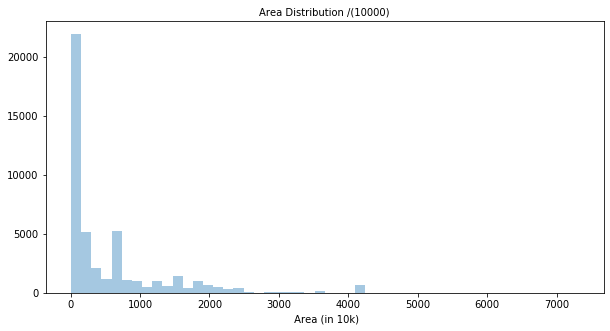

In [ ]:
plt.figure(figsize=(10, 5))
sns.distplot((image_df['Height'] * image_df['Width'])/10000, kde=False);
plt.title("Area Distribution /(10000)", fontsize=10)
plt.xlabel(" Area (in 10k)", fontsize=10)
plt.show()

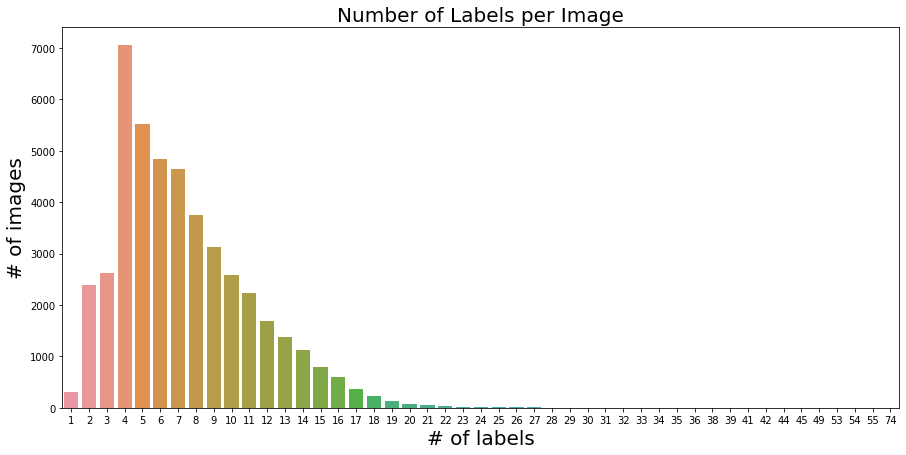

In [ ]:
# number of labels per image
labels_per_image = image_df['CategoryId'].map(lambda x:len(x)).value_counts().to_frame().reset_index().sort_values(by = 'index')
labels_per_image.columns = ['#labels','#images']

plt.figure(figsize=(15, 7))
sns.barplot(labels_per_image['#labels'],labels_per_image['#images'])
plt.title("Number of Labels per Image", fontsize=20)
plt.xlabel("# of labels", fontsize=20)
plt.ylabel("# of images", fontsize=20)
plt.show()

In [ ]:
segment_df['CategoryId'] = segment_df['CategoryId'].astype('int64')
labels_per_image2 = segment_df.merge(label_df, how='left', left_on='CategoryId', right_on='Id')
labels_per_image3 = labels_per_image2.groupby('Labels')['ImageId'].nunique().to_frame().reset_index()
labels_per_image3.head()

Labels  ImageId
0     applique     1687
1  bag, wallet     6907
2         bead     1755
3         belt     6667
4          bow      391

In [ ]:
labels_per_image4 = labels_per_image2.groupby('Labels')['ImageId'].count().to_frame().reset_index()
labels_per_image4.head()

Labels  ImageId
0     applique     3529
1  bag, wallet     7217
2         bead     5084
3         belt     6851
4          bow      528

In [ ]:
labels_per_image4.to_csv('word_cloud_data.csv')

In [ ]:
d = {}
for i in range(len(labels_per_image4)):
    d[labels_per_image4.iloc[i,0]] = labels_per_image4.iloc[i,1]

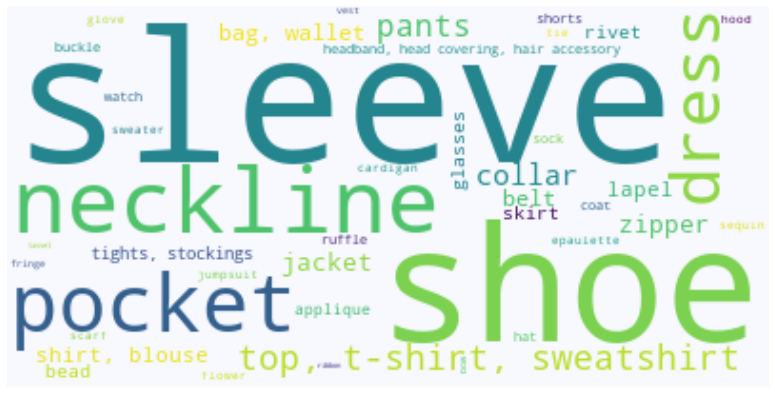

In [ ]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color='Ghostwhite')
wordcloud.generate_from_frequencies(frequencies=d)

plt.figure(figsize=(25, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

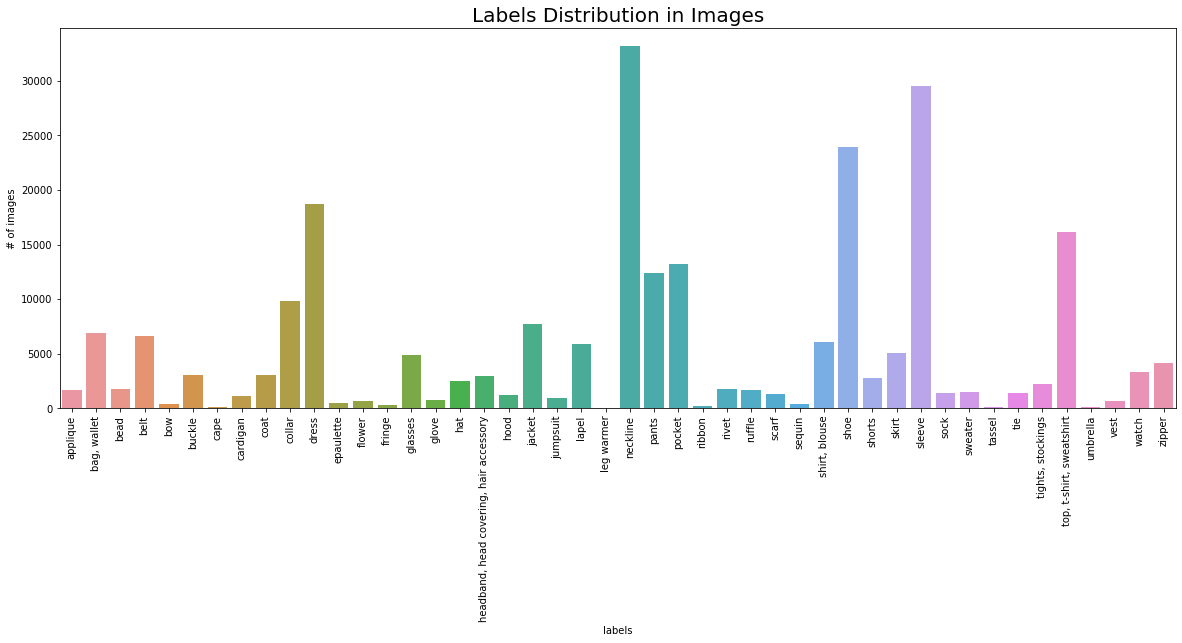

In [ ]:
plt.figure(figsize=(20, 7))
sns.barplot(labels_per_image3['Labels'],labels_per_image3['ImageId'])
plt.xticks(rotation=90)
plt.title("Labels Distribution in Images", fontsize=20)
plt.xlabel("labels", fontsize=10)
plt.ylabel("# of images", fontsize=10)
plt.show()

## Data Setup

In [ ]:
# Since we are training on ~5k images, we will fetch train data for those 5k images

images = os.listdir(TRAIN_IMAGE_DIR)
uploaded_images = pd.DataFrame(images, columns = ['image_name'])
image_df = image_df[image_df.index.isin(uploaded_images['image_name'])]

In [ ]:
image_df.shape

(4732, 4)

In [ ]:
# Partition data in train and test
FOLD = 0
N_FOLDS = 5

kf = KFold(n_splits=N_FOLDS, random_state=42, shuffle=True)
splits = kf.split(image_df) # ideally, this should be multilabel stratification

def get_fold():    
    for i, (train_index, valid_index) in enumerate(splits):
        if i == FOLD:
            return image_df.iloc[train_index], image_df.iloc[valid_index]
        
train_df, valid_df = get_fold()

## Setting up Mask RCNN

In [ ]:
# import matterport Mask-RCNN implementation
!git clone https://www.github.com/matterport/Mask_RCNN.git;
os.chdir('Mask_RCNN')

!rm -rf .git # to prevent an error when the kernel is committed
!rm -rf images assets # to prevent displaying images at the bottom of a kernel

sys.path.append(ROOT_DIR/'Mask_RCNN')
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.24 MiB | 38.72 MiB/s, done.
Resolving deltas: 100% (559/559), done.


Using TensorFlow backend.


In [ ]:
!pwd

/content/Mask_RCNN


In [ ]:
os.chdir(ROOT_DIR)
!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
!ls -lh mask_rcnn_coco.h5

COCO_WEIGHTS_PATH = '/content/mask_rcnn_coco.h5'

-rw-r--r-- 1 root root 246M Nov 26  2017 mask_rcnn_coco.h5


In [ ]:
# # Already have trained weights, we will continue on those weights
# pre_trained_weight = '/content/drive/My Drive/Projects/iMaterialist/trained weights/weights_0.08133.h5'

In [ ]:
# Set configuration

NUM_CATS = 46  # classification ignoring attributes (only categories)
IMAGE_SIZE = 512 # the image size is set to 512, which is the same as the size of submission masks

class FashionConfig(Config):
    NAME = "fashion"
    NUM_CLASSES = NUM_CATS + 1 # +1 for the background class
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4 # Batch size - memory error occurs when IMAGES_PER_GPU is too high
    #https://datascience.stackexchange.com/questions/29719/how-to-set-batch-size-steps-per-epoch-and-validation-steps
    
    BACKBONE = 'resnet50' #resnet50 will be lighter than resnet101 for training
    
    IMAGE_MIN_DIM = IMAGE_SIZE
    IMAGE_MAX_DIM = IMAGE_SIZE    
    IMAGE_RESIZE_MODE = "none"
    
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)
    #DETECTION_NMS_THRESHOLD = 0.7

    STEPS_PER_EPOCH = 500
    VALIDATION_STEPS = 100

    MAX_GT_INSTANCES = 50
    DETECTION_MAX_INSTANCES = 50

    ## balance out losses
    # https://stackoverflow.com/questions/55360262/what-exactly-are-the-losses-in-matterport-mask-r-cnn
    # https://stackoverflow.com/questions/46272841/what-is-the-loss-function-of-the-mask-rcnn
    LOSS_WEIGHTS = {
          "rpn_class_loss": 1.0, # How well the Region Proposal Network separates background with objetcs
          "rpn_bbox_loss": 0.8, # How well the RPN localize objects
          "mrcnn_class_loss": 6.0, # How well the Mask RCNN localize objects
          "mrcnn_bbox_loss": 6.0, # How well the Mask RCNN recognize each class of object
          "mrcnn_mask_loss": 6.0 # How well the Mask RCNN segment objects
    }
    
config = FashionConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        50
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                59
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              none
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 0.8, 'mrcnn_class_loss': 6.0, 'mrcnn_bbox_loss': 6.0, 'mrcnn_mask_loss': 6.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                 

In [ ]:
# resizing image to 512X512;
def resize_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)  
    return img

In [ ]:
#  MaskRCNN Class

class FashionDataset(utils.Dataset):

    def __init__(self, df):
        super().__init__(self)
        
        # Add classes
        for i, name in enumerate(label_names):
            self.add_class("fashion", i+1, name)
        
        # Add images 
        for i, row in df.iterrows():
            self.add_image("fashion", 
                           image_id=row.name, 
                           path=str(TRAIN_IMAGE_DIR/row.name), 
                           labels=row['CategoryId'],
                           annotations=row['EncodedPixels'], 
                           height=row['Height'], width=row['Width'])

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path'], [label_names[int(x)] for x in info['labels']]
    
    def load_image(self, image_id):
        return resize_image(self.image_info[image_id]['path'])

    def load_mask(self, image_id):
        info = self.image_info[image_id]
                
        mask = np.zeros((IMAGE_SIZE, IMAGE_SIZE, len(info['annotations'])), dtype=np.uint8)
        labels = []
        
        for m, (annotation, label) in enumerate(zip(info['annotations'], info['labels'])):
            sub_mask = np.full(info['height']*info['width'], 0, dtype=np.uint8)
            annotation = [int(x) for x in annotation.split(' ')]
            
            for i, start_pixel in enumerate(annotation[::2]):
                sub_mask[start_pixel: start_pixel+annotation[2*i+1]] = 1

            sub_mask = sub_mask.reshape((info['height'], info['width']), order='F')
            sub_mask = cv2.resize(sub_mask, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
            
            mask[:, :, m] = sub_mask
            labels.append(int(label)+1)
            
        return mask, np.array(labels)

('/content/drive/My Drive/myntra /Train large/100428b9168fbbd8942ec032eb53f7a0.jpg', ['skirt', 'bag, wallet', 'top, t-shirt, sweatshirt', 'neckline', 'sleeve', 'sleeve', 'tights, stockings', 'tights, stockings'])


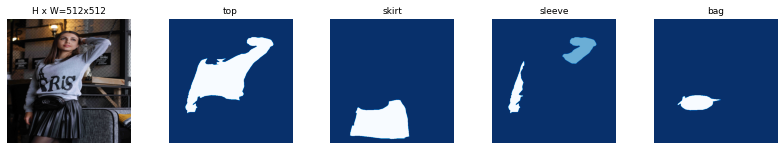

In [ ]:
# Visualizing random images
dataset = FashionDataset(image_df)
dataset.prepare()

for i in range(1):
    image_id = random.choice(dataset.image_ids)
    print(dataset.image_reference(image_id))
    
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names, limit=4)

In [ ]:
# Prepare Data
train_dataset = FashionDataset(train_df)
train_dataset.prepare()

valid_dataset = FashionDataset(valid_df)
valid_dataset.prepare()

## Training Model

In [ ]:
# Image augmentation
augmentation = iaa.Sequential([
    iaa.OneOf([ ## rotate
        iaa.Affine(rotate=0),
        iaa.Affine(rotate=90),
        iaa.Affine(rotate=180),
        iaa.Affine(rotate=270),
    ]),
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.OneOf([ ## brightness or contrast
        iaa.Multiply((0.9, 1.1)),
        iaa.ContrastNormalization((0.9, 1.1)),
    ]),
    iaa.OneOf([ ## blur or sharpen
        iaa.GaussianBlur(sigma=(0.0, 0.3)),
        iaa.Sharpen(alpha=(0.0, 0.3)),
    ]),
])

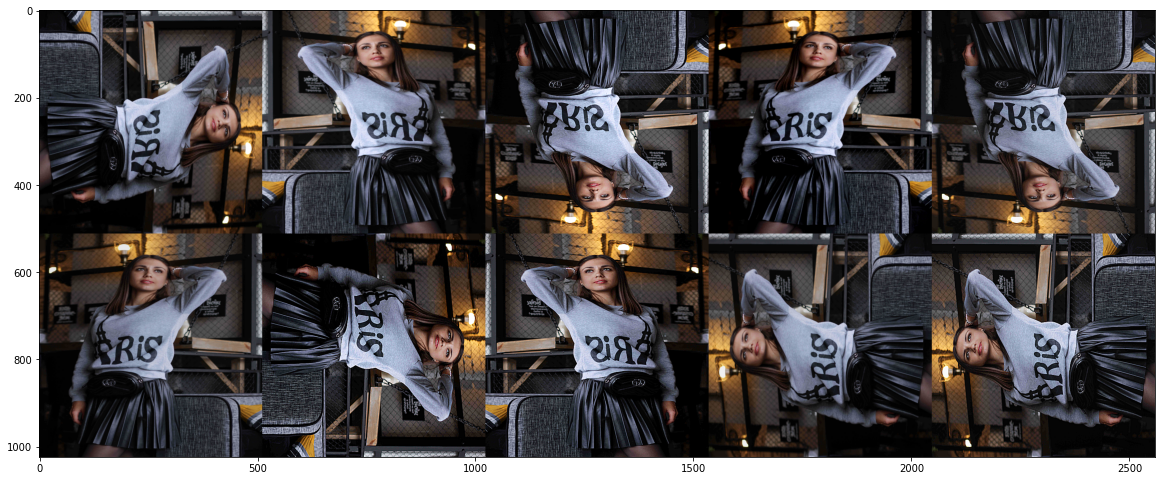

In [ ]:
# sample augmentation output
imggrid = augmentation.draw_grid(image, cols=5, rows=2)
plt.figure(figsize=(20, 10))
_ = plt.imshow(imggrid.astype(int))

In [ ]:
# initiating Mask R-CNN training

model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR);
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
    'mrcnn_class_logits', 'mrcnn_bbox_fc', 'mrcnn_bbox', 'mrcnn_mask'])

In [ ]:
# Declaring learning rate
LR = 0.0001

In [ ]:
## train head layer alone

# %%time
# model.train(train_dataset, valid_dataset,
#             learning_rate=LR*2,
#             epochs=2, # EPOCHS[0],
#             layers='heads',
#             augmentation=augmentation)
# history = model.keras_model.history.history
# history

In [ ]:
# Train all layers
%%time
model.train(train_dataset, valid_dataset,
            learning_rate=LR/4,
            epochs=2,
            layers='all',
            augmentation=augmentation)

# new_history = model.keras_model.history.history
# for k in new_history: history[k] = history[k] + new_history[k]
history = model.keras_model.history.history


Starting at epoch 0. LR=2.5e-05

Checkpoint Path: /content/fashion20191211T1601/mask_rcnn_fashion_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b          (

In [ ]:
#reducing learning rate and training again

%%time
model.train(train_dataset, valid_dataset,
            learning_rate=LR/8,
            epochs=5,
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]


Starting at epoch 2. LR=1.25e-05

Checkpoint Path: /content/fashion20191211T1601/mask_rcnn_fashion_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b          

In [ ]:
epochs = range(1, len(history['loss'])+1)
pd.DataFrame(history, index=epochs)

val_loss  val_rpn_class_loss  ...  mrcnn_bbox_loss  mrcnn_mask_loss
1  6.307518            0.045938  ...         1.922910         1.852573
2  6.460531            0.055555  ...         1.906473         1.845215
3  6.349557            0.053273  ...         1.859340         1.815950
4  6.437570            0.059940  ...         1.844846         1.822738
5  6.350489            0.089672  ...         1.848320         1.811695

[5 rows x 12 columns]

In [ ]:
# find best epoch
best_epoch = np.argmin(history["val_loss"]) + 1
print("Best epoch: ", best_epoch)
print("Valid loss: ", history["val_loss"][best_epoch-1])

Best epoch:  1
Valid loss:  6.307517833709717


In [ ]:
# Picking the location of our best model weights
glob_list = glob.glob(f'/content/fashion*/mask_rcnn_fashion_{best_epoch:04d}.h5')
model_path = glob_list[0] if glob_list else ''

In [ ]:
# model_path = '/content/fashion20191109T2055/mask_rcnn_fashion_0007.h5'

## Prediction

In [ ]:
# Prediction, this cell defines InferenceConfig and loads the best trained model.

class InferenceConfig(FashionConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

model.load_weights(model_path, by_name=True)



Instructions for updating:
Use `tf.cast` instead.
Re-starting from epoch 1


In [ ]:
# Since the submission system does not permit overlapped masks, we have to fix them
def refine_masks(masks, rois):
    areas = np.sum(masks.reshape(-1, masks.shape[-1]), axis=0)
    mask_index = np.argsort(areas)
    union_mask = np.zeros(masks.shape[:-1], dtype=bool)
    for m in mask_index:
        masks[:, :, m] = np.logical_and(masks[:, :, m], np.logical_not(union_mask))
        union_mask = np.logical_or(masks[:, :, m], union_mask)
    for m in range(masks.shape[-1]):
        mask_pos = np.where(masks[:, :, m]==True)
        if np.any(mask_pos):
            y1, x1 = np.min(mask_pos, axis=1)
            y2, x2 = np.max(mask_pos, axis=1)
            rois[m, :] = [y1, x1, y2, x2]
    return masks, rois

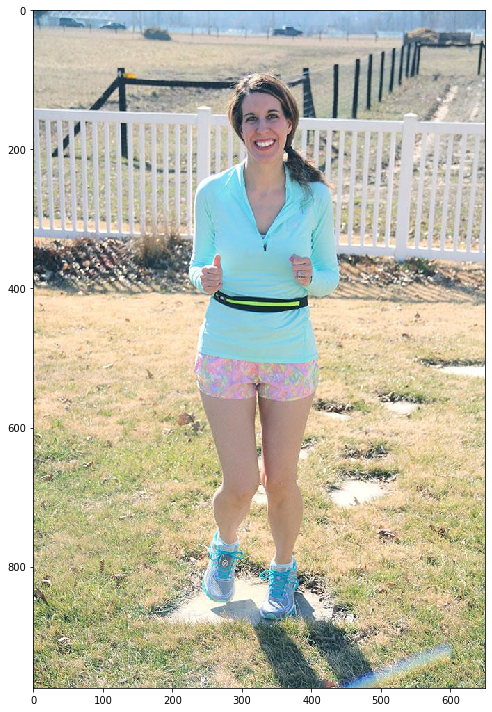

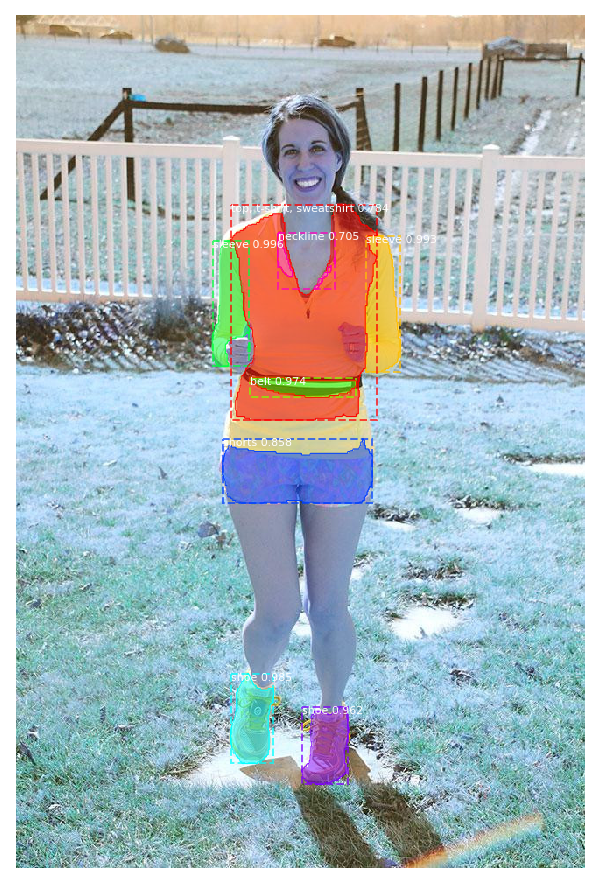

In [ ]:
# Let’s load an image and try to see how the model performs. You can use any of your images to test the model.

# Load a random image from the images folder
import skimage.io
image_path = str(ROOT_DIR/'test_image.jpg')

# original image
plt.figure(figsize=(12,10))
skimage.io.imshow(skimage.io.imread(image_path))

img = skimage.io.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

result = model.detect([resize_image(image_path)])
r = result[0]

if r['masks'].size > 0:
    masks = np.zeros((img.shape[0], img.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
    for m in range(r['masks'].shape[-1]):
        masks[:, :, m] = cv2.resize(r['masks'][:, :, m].astype('uint8'), 
                                    (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
    
    y_scale = img.shape[0]/IMAGE_SIZE
    x_scale = img.shape[1]/IMAGE_SIZE
    rois = (r['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)
    
    masks, rois = refine_masks(masks, rois)
else:
    masks, rois = r['masks'], r['rois']
    
visualize.display_instances(img, rois, masks, r['class_ids'], 
                            ['bg']+label_names, r['scores'])